# EDA

In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

In [2]:
# dirs
input_dir = '../input/'
working_dir = '../working/'
output_dir = '../output/'

In [3]:
# read data
train = pd.read_pickle(os.path.join(input_dir, 'train.pkl'))
test = pd.read_pickle(os.path.join(input_dir, 'test.pkl'))
sample_submission = pd.read_csv(os.path.join(input_dir, 'sample_submission.csv'), dtype={'fullVisitorId': 'str'})

In [4]:
# drop cols which are not use in learning
drop_cols = ['fullVisitorId', 'sessionId', 'visitId', 'visitStartTime', 'gclId', 'source']
train = train.drop(drop_cols, axis=1)
test = test.drop(drop_cols, axis=1)

In [5]:
# divide train into development and validation
dev = train[train['date']<=datetime.datetime(2017,5,31)]
val = train[train['date']>datetime.datetime(2017,5,31)]

In [6]:
def divide_y_X(df):
    y = df['transactionRevenue'].fillna(0)
    X = df.drop('transactionRevenue', axis=1)
    return y, X

In [123]:
dev_y, dev_X = divide_y_X(dev)
val_y, val_X = divide_y_X(val)

In [4]:
y = train['transactionRevenue'].fillna(0)
drop_cols = ['date', 'fullVisitorId', 'sessionId', 'visitId', 'visitStartTime', 'gclId', 'source']
X = train.drop(drop_cols+['transactionRevenue'], axis=1)

In [35]:


gbm_params = {
    'learning_rate':[0.2],
    'n_estimators':[100]
}

params = {
    "objective" : "regression",
    "metric" : "rmse", 
    "num_leaves" : 30,
    "min_child_samples" : 100,
    "learning_rate" : 0.1,
    "bagging_fraction" : 0.7,
    "feature_fraction" : 0.5,
    "bagging_frequency" : 5,
#     "bagging_seed" : 2018,
    "verbosity" : -1,
    "random_state": 0
}

gbm = GridSearchCV(
    estimator=lgb.LGBMRegressor(**params)
    ,param_grid=gbm_params
    ,cv=5
)

In [36]:
gbm.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMRegressor(bagging_fraction=0.7, bagging_frequency=5, boosting_type='gbdt',
       class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
       learning_rate=0.1, max_depth=-1, metric='rmse',
       min_child_samples=100, min_child_weight=0.001, min_split_gain=0.0,
       n_est... silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
       verbosity=-1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.2], 'n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
pred = gbm.predict(X)
pred[pred<0] = 0
pred = pd.Series(data=pred, name='pred')

In [39]:
pred_df = pd.concat([y, pred], axis=1)
pred_df[pred_df['transactionRevenue']>0].head()

,transactionRevenue,pred
752,37860000.0,4.374120e+06
753,306670000.0,1.515469e+07
799,68030000.0,8.888524e+06
802,26250000.0,8.925742e+06
859,574150000.0,3.307807e+07


In [40]:
pred_test = gbm.predict(test.drop(drop_cols, axis=1))
pred_test[pred_test<0] = 0

In [41]:
pred_test_df = pd.DataFrame(
    {
        'fullVisitorId': test['fullVisitorId'],
        'PredictedLogRevenue': pred_test
    }
)

In [45]:
submission = pred_test_df.groupby('fullVisitorId')['PredictedLogRevenue'].sum()
submission = submission.to_frame()
submission['PredictedLogRevenue'] = np.log(submission['PredictedLogRevenue'].values+1)
submission.to_csv(os.path.join(output_dir, 'submission_20181003.csv'))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CB4EAB3A90>]],
      dtype=object)

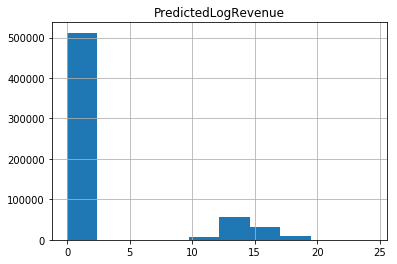

In [43]:
submission.hist()

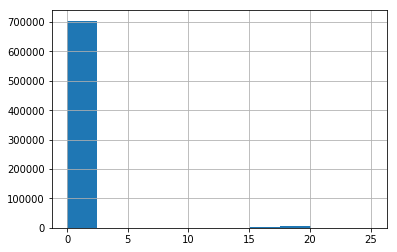

In [44]:
np.log(train.groupby('fullVisitorId')['transactionRevenue'].sum()+1).hist()

In [ ]:
submission

In [74]:
# trainとtestで重複していない値の数
col_diff_dict = {}
for col in test.columns:
    cnt = len(set(train[col].unique()) ^ set(test[col].unique()))
    col_diff_dict[col] = cnt
col_diff_dict

{'channelGrouping': 0,
 'date': 638,
 'fullVisitorId': 1316051,
 'sessionId': 1706608,
 'visitId': 1665797,
 'visitNumber': 84,
 'visitStartTime': 1667423,
 'browser': 95,
 'deviceCategory': 0,
 'isMobile': 0,
 'operatingSystem': 6,
 'city': 531,
 'continent': 0,
 'country': 15,
 'metro': 43,
 'networkDomain': 30150,
 'region': 214,
 'subContinent': 0,
 'bounces': 0,
 'hits': 91,
 'newVisits': 0,
 'pageviews': 89,
 'adContent': 57,
 'adNetworkType': 1,
 'gclId': 58925,
 'isVideoAd': 0,
 'page': 4,
 'slot': 1,
 'campaign': 29,
 'isTrueDirect': 0,
 'keyword': 4710,
 'medium': 0,
 'referralPath': 2720,
 'source': 296}